In [8]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
# Charger les données
embeddings = np.load("/kaggle/input/data-embd/embeddings.npy")  # Shape: (5000, 128, 768)
labels = np.load("/kaggle/input/lab-coded/labels.npy")  # Shape: (5000, 10)

In [3]:
# Préparer les indices pour chaque classe
num_classes = labels.shape[1]
train_embeddings = []
test_embeddings = []
train_labels = []
test_labels = []

for class_id in range(num_classes):
    class_indices = np.where(labels[:, class_id] == 1)[0]
    train_idx, test_idx = train_test_split(class_indices, test_size=0.2, random_state=42)
    train_embeddings.append(embeddings[train_idx])
    test_embeddings.append(embeddings[test_idx])
    train_labels.append(labels[train_idx])
    test_labels.append(labels[test_idx])

train_embeddings = np.vstack(train_embeddings)
test_embeddings = np.vstack(test_embeddings)
train_labels = np.vstack(train_labels)
test_labels = np.vstack(test_labels)

In [6]:
def build_lstm_model_with_attention(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Masking(mask_value=0.0)(inputs)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)
    )(x)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)
    )(x)
    
    # Mécanisme d'attention
    score = tf.keras.layers.Dense(64, activation='tanh')(x)
    attention_weights = tf.keras.layers.Dense(1, activation='softmax')(score)
    attention_weights = tf.keras.layers.Permute([2, 1])(attention_weights)
    attention_weights = tf.keras.layers.Reshape((-1, 1))(attention_weights)
    context_vector = tf.keras.layers.Multiply()([x, attention_weights])
    context_vector = tf.keras.layers.GlobalAveragePooling1D()(context_vector)
    
    # Couches entièrement connectées
    x = tf.keras.layers.Dense(256, activation='relu')(context_vector)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    # Compilation du modèle
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [7]:
# Construire le modèle
input_shape = train_embeddings.shape[1:]  # (128, 768)
model = build_lstm_model_with_attention(input_shape, num_classes)

# Entraîner le modèle
history = model.fit(
    train_embeddings, train_labels,
    validation_data=(test_embeddings, test_labels),
    batch_size=32,
    epochs=20
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'permute_1' (of type Permute) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.1889 - loss: 2.2089

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


125/125 ━━━━━━━━━━━━━━━━━━━━ 69s 486ms/step - accuracy: 0.1897 - loss: 2.2074 - val_accuracy: 0.5900 - val_loss: 1.2310
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 470ms/step - accuracy: 0.5539 - loss: 1.3627 - val_accuracy: 0.6990 - val_loss: 0.9609
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 470ms/step - accuracy: 0.6754 - loss: 1.0226 - val_accuracy: 0.7030 - val_loss: 0.9505
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 471ms/step - accuracy: 0.6915 - loss: 0.9868 - val_accuracy: 0.7250 - val_loss: 0.8986
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 469ms/step - accuracy: 0.7154 - loss: 0.8757 - val_accuracy: 0.7190 - val_loss: 0.9513
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 473ms/step - accuracy: 0.7555 - loss: 0.7875 - val_accuracy: 0.7370 - val_loss: 0.8315
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 473ms/step - accuracy: 0.7609 - loss: 0.7646 - val_accuracy: 0.7500 - val_loss: 0.8710
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 472ms/step - accuracy: 0.7704 - loss: 0.7267 - val

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'permute_1' (of type Permute) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step
              precision    recall  f1-score   support

           0       0.73      0.66      0.69       100
           1       0.86      0.77      0.81       100
           2       0.71      0.89      0.79       100
           3       0.75      0.59      0.66       100
           4       0.57      0.62      0.59       100
           5       0.67      0.61      0.64       100
           6       0.79      0.83      0.81       100
           7       0.96      1.00      0.98       100
           8       0.76      0.68      0.72       100
           9       0.81      0.95      0.88       100

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000



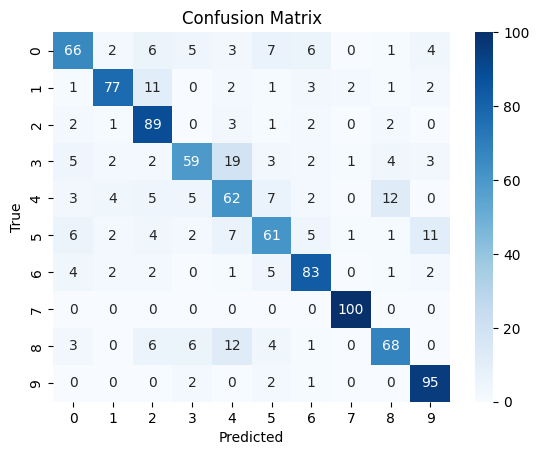

In [9]:
# Prédictions sur les données de test
predictions = model.predict(test_embeddings)
predictions = np.argmax(predictions, axis=1)  # Convertir les probabilités en classes

# Générer un rapport de classification
print(classification_report(np.argmax(test_labels, axis=1), predictions))

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()